# Predicting Diabetes Using BRFSS Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Diabetes_2022.csv')

In [4]:
y = df.Diabetes_01
X = df.drop(['Diabetes_01'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

X_train: (228311, 24) X_test: (57078, 24)
y_train: (228311,) y_test: (57078,)


In [ ]:
#scoring='accuracy'/scoring="recall"
'''def optimize_model(model, param_grid, cv = 5, X_train = X_train, y_train = y_train):
    optimizer = GridSearchCV(model, param_grid = param_grid, scoring="accuracy", cv = cv, n_jobs = -1, verbose = True)
    optimizer.fit(X_train, y_train)
    print('Best parameters found:')
    print(optimizer.best_params_)
    print('\nBest score: %0.6f' % (optimizer.best_score_))
    
    return optimizer.best_estimator_'''

In [7]:
def optimize_model(model, param_grid, primary_metric="recall", cv=5, X_train = X_train, y_train = y_train):
    # Define the scoring metrics dictionary
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score)
    }
    
    # Perform grid search with multiple scoring metrics and refit based on the primary metric
    optimizer = GridSearchCV(estimator=model, 
                             param_grid=param_grid, 
                             scoring=scoring, 
                             refit=primary_metric, 
                             cv=cv, 
                             n_jobs=-1, 
                             verbose=True)
    
    optimizer.fit(X_train, y_train)
 
    print('Best parameters found:')
    print(optimizer.best_params_)
    print(f'\nBest {primary_metric} score: %0.6f' % (optimizer.best_score_))
    
    # Print additional metrics
    if primary_metric == 'recall':
        print(f"Corresponding accuracy: {optimizer.cv_results_['mean_test_accuracy'][optimizer.best_index_]:0.6f}")
    else:
        print(f"Corresponding recall: {optimizer.cv_results_['mean_test_recall'][optimizer.best_index_]:0.6f}")
    
    return optimizer.best_estimator_


In [8]:
def evaluate_model(model, X_test = X_test, y_test = y_test):
    y_pred = model.predict(X_test)
    print('\nClassification report: ')
    print(classification_report(y_test, y_pred))

#### GaussianNB

In [9]:
gaussianNB_model = GaussianNB()
gaussianNB_model.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, gaussianNB_model.predict(X_test)), 6))
evaluate_model(gaussianNB_model)

Best score: 0.773188

Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     48132
           1       0.34      0.48      0.40      8946

    accuracy                           0.77     57078
   macro avg       0.62      0.66      0.63     57078
weighted avg       0.81      0.77      0.79     57078



In [10]:
print('Cross validation - GaussianNB:', np.round(cross_val_score(GaussianNB(), X, y, cv = 5).mean(), 6))

Cross validation - GaussianNB: 0.774876


#### MultinomialNB

In [11]:
multinomialNB_model = MultinomialNB()
multinomialNB_model.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, multinomialNB_model.predict(X_test)), 6))
evaluate_model(multinomialNB_model)

Best score: 0.781702

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     48132
           1       0.31      0.32      0.32      8946

    accuracy                           0.78     57078
   macro avg       0.59      0.59      0.59     57078
weighted avg       0.78      0.78      0.78     57078



In [12]:
print('Cross validation - MultinomialNB:', np.round(cross_val_score(MultinomialNB(), X, y, cv = 5).mean(), 6))

Cross validation - MultinomialNB: 0.780832


GaussianNB and MultinomialNB gave very similar results. Cross-validation of very basic layering models yielded accuracy scores of around 0.77.\
We can see that both models detect healthy individuals more accurately than those who are pre-diabetic or diagnosed with diabetes.

### Logistic Regression

In [13]:
lr_baseline = LogisticRegression(random_state = 0)
lr_baseline.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, lr_baseline.predict(X_test)), 6))
evaluate_model(lr_baseline)

Best score: 0.847752

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.97      0.92     48132
           1       0.54      0.17      0.26      8946

    accuracy                           0.85     57078
   macro avg       0.70      0.57      0.59     57078
weighted avg       0.81      0.85      0.81     57078



In [14]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10,100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 200]
}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score)
}
grid_search = GridSearchCV(estimator=lr_baseline, param_grid=param_grid, scoring=scoring,  refit='recall', cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_recall_score = grid_search.best_score_
print("Best Recall Score (used for refit):", best_recall_score)
best_index = grid_search.best_index_  
best_accuracy_score = grid_search.cv_results_['mean_test_accuracy'][best_index]
print("Best Accuracy Score:", best_accuracy_score)

Best Parameters: {'C': 100, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Recall Score (used for refit): 0.16524304854855773
Best Accuracy Score: 0.846967512659058


In [15]:
lr_model = grid_search.best_estimator_ 

<Figure size 200x100 with 0 Axes>

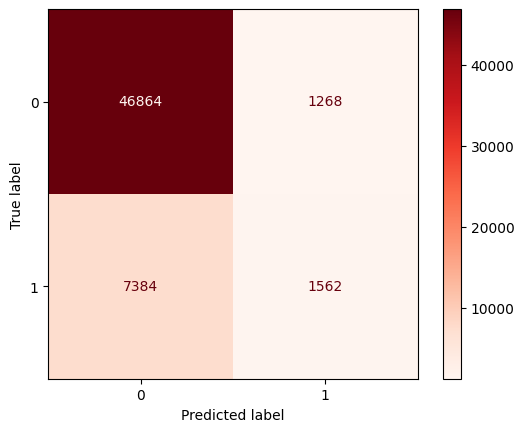

In [16]:
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()


### SVM

In [ ]:
svm_model = Pipeline([("scaler", StandardScaler()), ("model", SVC(kernel='rbf'))])

svm_param_grid = {'model__C' : 10**np.arange(-3,4, dtype = float),
                  'model__class_weight' : ['balanced', None]}

In [ ]:
svm_baseline = SVC(random_state = 0)
svm_baseline.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, svm_baseline.predict(X_test)), 6))
evaluate_model(svm_baseline)

In [ ]:
y_pred = svm_baseline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()


The dataset for the SVM classifier is too large.

### Decision Tree Classifier

In [17]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier())])

tree_param_grid = {'model__criterion': ['gini', 'entropy'],
                   'model__max_depth': [2, 5, 10, 20, 30],
                   'model__min_samples_leaf': [5, 10, 20, 30]}

In [18]:
tree_baseline = DecisionTreeClassifier(random_state = 0)
tree_baseline.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, tree_baseline.predict(X_test)), 6))
evaluate_model(tree_baseline)

Best score: 0.778846

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     48132
           1       0.31      0.32      0.31      8946

    accuracy                           0.78     57078
   macro avg       0.59      0.59      0.59     57078
weighted avg       0.78      0.78      0.78     57078



In [19]:
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found:
{'model__criterion': 'entropy', 'model__max_depth': 30, 'model__min_samples_leaf': 5}

Best recall score: 0.256615
Corresponding accuracy: 0.815199

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     48132
           1       0.38      0.26      0.31      8946

    accuracy                           0.82     57078
   macro avg       0.62      0.59      0.60     57078
weighted avg       0.79      0.82      0.80     57078



In [20]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier(criterion = 'entropy'))])
tree_param_grid = {'model__min_samples_leaf': [2,3,4,5,6,7],
                   'model__max_depth': [30,35,40,45,50]}
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:
{'model__max_depth': 40, 'model__min_samples_leaf': 3}

Best recall score: 0.280627
Corresponding accuracy: 0.803601

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     48132
           1       0.35      0.28      0.31      8946

    accuracy                           0.81     57078
   macro avg       0.61      0.59      0.60     57078
weighted avg       0.79      0.81      0.80     57078



<Figure size 200x100 with 0 Axes>

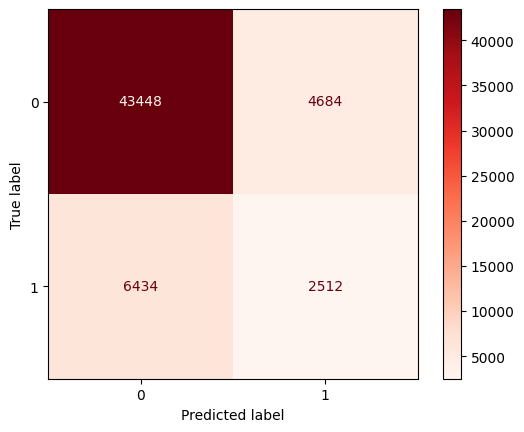

In [21]:
y_pred = tree_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

### Random Forest Classifier

In [22]:
forest_classifier= RandomForestClassifier(random_state = 0)
forest_classifier.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, forest_classifier.predict(X_test)), 6))
evaluate_model(forest_classifier)

Best score: 0.840026

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     48132
           1       0.47      0.19      0.27      8946

    accuracy                           0.84     57078
   macro avg       0.67      0.57      0.59     57078
weighted avg       0.80      0.84      0.81     57078



<Figure size 200x100 with 0 Axes>

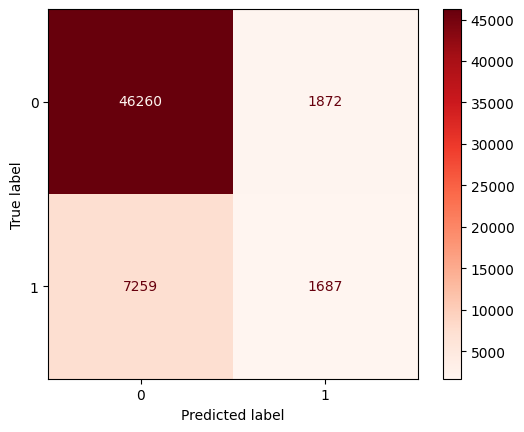

In [23]:
y_pred = forest_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

#### _OPTIONAL_

In [ ]:
forest_model = Pipeline([("scaler", StandardScaler()), ("model", RandomForestClassifier())])

forest_param_grid = {'model__n_estimators': [200, 500, 1000],
                     'model__max_depth' : [5, 15, 50],
                     'model__min_samples_leaf': [5, 10, 20],
                     'model__criterion': ['gini', 'entropy']}

In [ ]:
forest_model = optimize_model(forest_model, forest_param_grid)
evaluate_model(forest_model)

In [ ]:
forest_model = Pipeline([("scaler", StandardScaler()), ("model", RandomForestClassifier(min_samples_leaf = 10,
                                                                                        criterion = 'entropy'))])
forest_param_grid = {'model__n_estimators': [400, 500, 700],
                     'model__max_depth' : [35, 50, 100]}
forest_model = optimize_model(forest_model, forest_param_grid)
evaluate_model(forest_model)

#narrow the area and choose the best parameters

### XGBoost Classifier

In [24]:
xgb_classifier = xgb.XGBClassifier(eval_metric='error', random_state = 0)
xgb_classifier.fit(X_train, y_train)
print('Best score:', np.round(accuracy_score(y_test, xgb_classifier.predict(X_test)), 6))
evaluate_model(xgb_classifier)

Best score: 0.849732

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.97      0.92     48132
           1       0.56      0.18      0.27      8946

    accuracy                           0.85     57078
   macro avg       0.71      0.58      0.60     57078
weighted avg       0.82      0.85      0.82     57078



<Figure size 200x100 with 0 Axes>

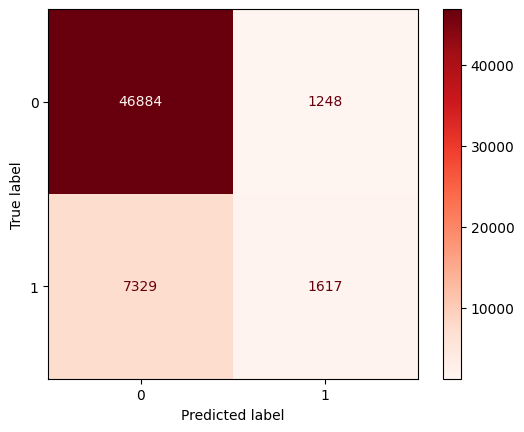

In [25]:
y_pred = xgb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

#### _OPTIONAL_

In [ ]:
xgb_model = Pipeline([("scaler", StandardScaler()), ("model", xgb.XGBClassifier(eval_metric='error'))])

xgb_param_grid  = {'model__n_estimators': [200, 400, 800],
                   'model__max_depth': [5, 10, 20],
                   'model__learning_rate': [0.05, 0.1, 0.20],
                   'model__min_child_weight': [1, 10, 100]}

In [ ]:
xgb_model = optimize_model(xgb_model, xgb_param_grid)
evaluate_model(xgb_model)

In [ ]:
xgb_model = Pipeline([("scaler", StandardScaler()), ("model", xgb.XGBClassifier(eval_metric='error'))])
xgb_param_grid  = {'model__n_estimators': [800, 1000],
                   'model__max_depth': [1, 3, 5],
                   'model__learning_rate': [0.001, 0.01, 0.05],
                   'model__min_child_weight': [100, 200]}
xgb_model = optimize_model(xgb_model, xgb_param_grid)
evaluate_model(xgb_model)

#narrow the area for the best parameters

## Metrics

In [26]:
from sklearn import metrics
model_name = []
accuracy_score = []
f1_score = []
roc_auc_score = []
recall_score = []
precision_score = []
    
def metrics_models(name, model, X_test = X_test, y_test = y_test):
    models = list()
    models.append((name, model))
    
    for name, model in models:
        model_name.append(name)
        accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
        f1_score.append(metrics.f1_score(y_test, model.predict(X_test)))
        roc_auc_score.append(metrics.roc_auc_score(y_test, model.predict(X_test)))
        recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
        precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))


In [27]:
metrics_models('Base GaussianNB', gaussianNB_model)
metrics_models('Base MultinomialNB', multinomialNB_model)
metrics_models('Base LinearRegression', lr_baseline)
metrics_models('LinearRegression', lr_model)
metrics_models('Base DecisionTreeClassifier', tree_baseline)
metrics_models('DecisionTreeClassifier', tree_model)
metrics_models('RandomForestClassifier', forest_classifier)
metrics_models('XGBoostClassifier', xgb_classifier)

In [28]:
metric_df = pd.DataFrame({'Model': model_name,
                           'Accuracy': accuracy_score,
                           'F1-score': f1_score,
                           'AUC': roc_auc_score,
                           'Recall': recall_score,
                           'Precision': precision_score})

In [29]:
metric_df

,Model,Accuracy,F1-score,AUC,Recall,Precision
0,Base GaussianNB,0.773188,0.401258,0.655839,0.484909,0.342222
1,Base MultinomialNB,0.781702,0.316211,0.594590,0.322043,0.310586
2,Base LinearRegression,0.847752,0.264058,0.573598,0.174268,0.544724
3,LinearRegression,0.848418,0.265285,0.574129,0.174603,0.551943
4,Base DecisionTreeClassifier,0.778846,0.314303,0.593443,0.323385,0.305717
5,DecisionTreeClassifier,0.805214,0.311238,0.591740,0.280796,0.349083
6,RandomForestClassifier,0.840026,0.269812,0.574841,0.188576,0.474010
7,XGBoostClassifier,0.849732,0.273813,0.577411,0.180751,0.564398


Accuracy:
Accuracy is relatively high for models like Base LinearRegression (0.8478), LinearRegression (0.8484), RandomForestClassifier (0.8400), and XGBoostClassifier (0.8497). However, accuracy can be misleading with imbalanced data, as it may not properly reflect the model's ability to detect the minority class (diabetes positive cases).

F1-Score:
F1-scores are generally low across all models, with the highest being Base GaussianNB at 0.4013. This indicates that most models are struggling to balance precision and recall, which is critical for imbalanced data.

AUC (Area Under the Curve):
The AUC scores are also relatively low for all models, with the highest being 0.6558 for Base GaussianNB. This suggests that the models have limited ability to distinguish between positive and negative cases, which is crucial in a classification problem like predicting diabetes.

Recall:
Since recall is a key metric in predicting diabetes (as false negatives are particularly costly), it is concerning that all models have low recall, with the highest being Base GaussianNB at 0.4849. This implies that the models are not effectively identifying the positive cases (diabetes).

Precision:
Precision varies across models, with XGBoostClassifier showing the highest precision (0.5644). However, this comes at the cost of recall, as seen in the relatively low recall value (0.1808).

The accuracy for the Logistic Regression model and XGBoost Classifier are the best. I will also be focusing on the Recall value(False Negative) as it is important for this problem statement so i choose the Decision Tree Classifier as well.